# Carti Sentiment Analysis

In [4]:
import praw
from textblob import TextBlob
import matplotlib.pyplot as plt
from wordcloud import WordCloud

In [5]:
reddit = praw.Reddit(
    client_id="client_id",      
    client_secret="secret",  
    user_agent="CartiSentiment"
)

Fetching posts
Successfully fetched 3391 unique posts
Analyzing sentiment...
Generating visualizations...

=== Subreddit Mood Summary ===
Analyzed 3391 posts

Slightly Positive: 936 posts (27.6%)
Slightly Negative: 549 posts (16.2%)
Neutral: 1577 posts (46.5%)
Very Negative: 211 posts (6.2%)
Very Positive: 118 posts (3.5%)

=== Notable Posts ===
Most Positive Post: "@718edits Has the best Carti edits ive ever seen."
Most Negative Post: "Worst tweet of all time "


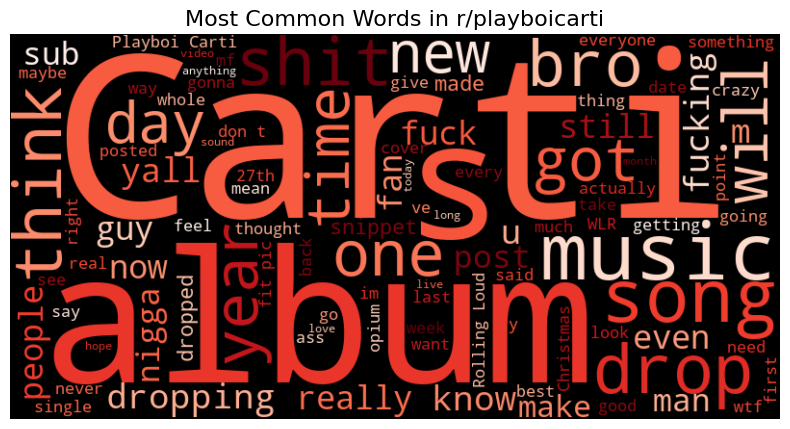

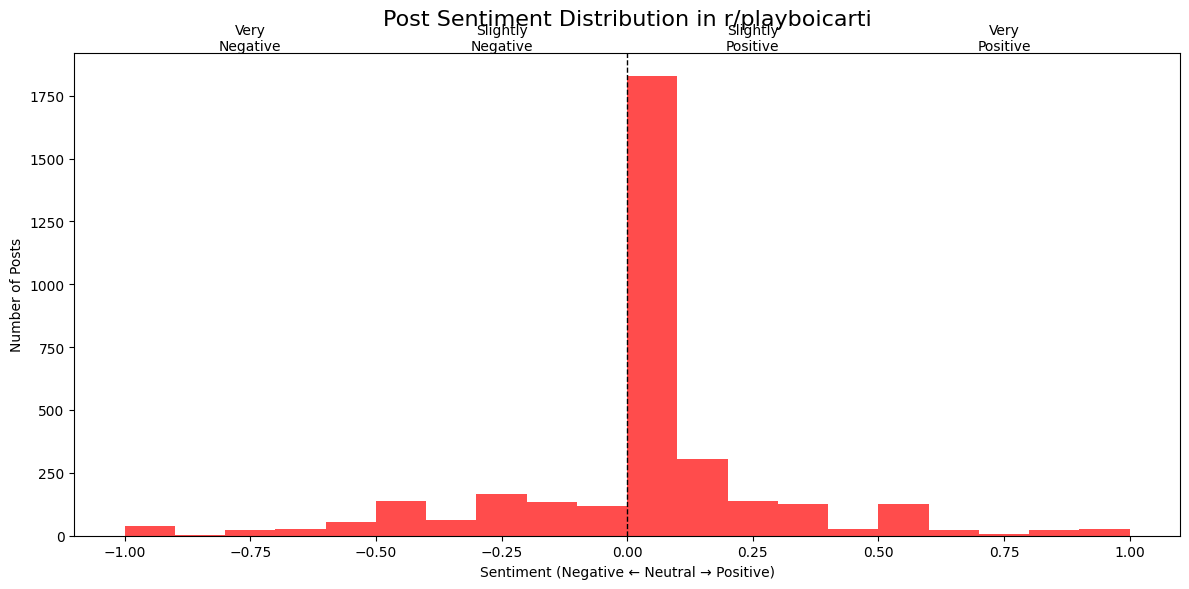

In [13]:
import praw
from textblob import TextBlob
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import numpy as np
import time

def fetch_posts(subreddit="playboicarti", limit=None, timeframe="all"):
    subreddit = reddit.subreddit(subreddit)
    posts = []
    
    sort_types = ["hot", "new", "top"]
    time_filters = ["all", "year", "month", "week"]
    
    seen_ids = set() 
    
    for sort_type in sort_types:
        try:
            if sort_type == "top":
                for time_filter in time_filters:
                    for post in getattr(subreddit, sort_type)(time_filter=time_filter, limit=None):
                        if post.id not in seen_ids:
                            seen_ids.add(post.id)
                            posts.append({
                                'title': post.title,
                                'text': post.selftext,
                                'score': post.score,
                                'full_text': post.title + " " + post.selftext
                            })
                        if limit and len(posts) >= limit:
                            return posts
            else:
                for post in getattr(subreddit, sort_type)(limit=None):
                    if post.id not in seen_ids:
                        seen_ids.add(post.id)
                        posts.append({
                            'title': post.title,
                            'text': post.selftext,
                            'score': post.score,
                            'full_text': post.title + " " + post.selftext
                        })
                    if limit and len(posts) >= limit:
                        return posts
                        
        except Exception as e:
            print(f"Warning: Error fetching {sort_type} posts: {str(e)}")
            continue
            
        time.sleep(2)
    
    print(f"Successfully fetched {len(posts)} unique posts")
    return posts

def analyze_sentiment(posts):
    results = []
    for post in posts:
        blob = TextBlob(post['full_text'])
        sentiment = blob.sentiment.polarity
        
        if sentiment > 0.5:
            label = "Very Positive"
        elif sentiment > 0:
            label = "Slightly Positive"
        elif sentiment == 0:
            label = "Neutral"
        elif sentiment > -0.5:
            label = "Slightly Negative"
        else:
            label = "Very Negative"
            
        results.append({
            'title': post['title'],
            'sentiment_score': sentiment,
            'sentiment_label': label,
            'post_score': post['score']
        })
    return results

def print_summary(results):
    sentiment_counts = {}
    for result in results:
        label = result['sentiment_label']
        sentiment_counts[label] = sentiment_counts.get(label, 0) + 1
    
    print("\n=== Subreddit Mood Summary ===")
    print(f"Analyzed {len(results)} posts\n")
    
    total = len(results)
    for label, count in sentiment_counts.items():
        percentage = (count / total) * 100
        print(f"{label}: {count} posts ({percentage:.1f}%)")
    
    most_positive = max(results, key=lambda x: x['sentiment_score'])
    most_negative = min(results, key=lambda x: x['sentiment_score'])
    
    print("\n=== Notable Posts ===")
    print(f"Most Positive Post: \"{most_positive['title']}\"")
    print(f"Most Negative Post: \"{most_negative['title']}\"")

def generate_wordcloud(posts):
    text = " ".join(p['full_text'] for p in posts)
    wordcloud = WordCloud(
        width=800, 
        height=400,
        background_color="black",
        colormap="Reds",
        max_words=100
    ).generate(text)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title("Most Common Words in r/playboicarti", fontsize=16)
    plt.show()

def plot_sentiment(results):
    scores = [r['sentiment_score'] for r in results]
    labels = [r['sentiment_label'] for r in results]
    
    plt.figure(figsize=(12, 6))
    
    plt.hist(scores, bins=20, color='red', alpha=0.7)
    plt.axvline(0, color='black', linestyle='dashed', linewidth=1)
    
    plt.title("Post Sentiment Distribution in r/playboicarti", fontsize=16, pad=20)
    plt.xlabel("Sentiment (Negative ← Neutral → Positive)")
    plt.ylabel("Number of Posts")
    
    plt.text(-0.75, plt.ylim()[1], "Very\nNegative", ha='center', va='bottom')
    plt.text(-0.25, plt.ylim()[1], "Slightly\nNegative", ha='center', va='bottom')
    plt.text(0.25, plt.ylim()[1], "Slightly\nPositive", ha='center', va='bottom')
    plt.text(0.75, plt.ylim()[1], "Very\nPositive", ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    print("Fetching posts")
    posts = fetch_posts(limit=10000)
    
    print("Analyzing sentiment...")
    results = analyze_sentiment(posts)
    
    print("Generating visualizations...")
    print_summary(results)
    generate_wordcloud(posts)
    plot_sentiment(results)